In [1]:
import scanpy as sc
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
import seaborn as sns
import copy
from matplotlib import gridspec
import matplotlib.patches as patches
import matplotlib
matplotlib.use('Agg')
from matplotlib import gridspec
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.font_manager as font_manager
import pandas as pd
font_dirs = ['/project/elkabetz_lab_data/tools/PythonFonts/', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
matplotlib.rcParams['font.family'] = 'tahoma'
import random
import scipy
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


In [2]:
adata_dict = {}
line_ = 'FOK1'
adata_dict[line_] = {}
for tx in ['sbnx','sbn']:
    print('loading: ',tx)
    pkl_file = open('/project/elkabetz_lab_data/sequencing/scrna/d50_organoids_exp3/analysis/data/'+line_+'/d50_'+tx+'.pkl', 'rb')
    adata_dict[line_][tx] = pkl.load(pkl_file)
    adata_dict[line_][tx].obs['line'] = [line_ for x in range(len(adata_dict[line_][tx].obs))]
    pkl_file.close()

line_ = 'KUCG2'
adata_dict[line_] = {}
for tx in ['sbnx','sbn']:
    print('loading: ',tx)
    pkl_file = open('/project/elkabetz_lab_data/sequencing/scrna/d50_organoids_exp3/analysis/data/'+line_+'/d50_'+tx+'.pkl', 'rb')
    adata_dict[line_][tx] = pkl.load(pkl_file)
    adata_dict[line_][tx].obs['line'] = [line_ for x in range(len(adata_dict[line_][tx].obs))]
    pkl_file.close()

line_ = 'zip13k5'
adata_dict[line_] = {}
for tx in ['sbnx','sbn','nt']:
    print('loading: ',tx)
    pkl_file = open('/project/elkabetz_lab_data/sequencing/scrna/d50_organoids_exp2/analysis/data/'+line_+'/d50_'+tx+'.pkl', 'rb')
    adata_dict[line_][tx] = pkl.load(pkl_file)
    adata_dict[line_][tx].obs['line'] = ['zip13k5' for x in range(len(adata_dict[line_][tx].obs))]
    pkl_file.close()

line_ = 'zip8k8'
adata_dict[line_] = {}
for tx in ['sbnx','sbn','nt']:
    print('loading: ',tx)
    pkl_file = open('/project/elkabetz_lab_data/sequencing/scrna/d50_organoids_exp2/analysis/data/'+line_+'/d50_'+tx+'.pkl', 'rb')
    adata_dict[line_][tx] = pkl.load(pkl_file)
    adata_dict[line_][tx].obs['line'] = ['zip8k8' for x in range(len(adata_dict[line_][tx].obs))]
    pkl_file.close()

adata_merged = adata_dict['zip13k5']['sbnx'].concatenate(adata_dict['zip13k5']['sbn'],adata_dict['zip13k5']['nt'],
    adata_dict['zip8k8']['sbnx'],adata_dict['zip8k8']['sbn'],adata_dict['zip8k8']['nt'],adata_dict['FOK1']['sbnx'],
    adata_dict['FOK1']['sbn'],adata_dict['KUCG2']['sbnx'],adata_dict['KUCG2']['sbn'])

loading:  sbnx
loading:  sbn
loading:  sbnx
loading:  sbn
loading:  sbnx
loading:  sbn
loading:  nt
loading:  sbnx
loading:  sbn
loading:  nt


In [3]:
genes = list(adata_merged.var_names)
mito_genes = [gene for gene in genes if gene[:3] == 'MT-' or (gene[:2] == 'MT' and '.' in gene)]
rb_genes = [gene for gene in genes if gene[:3] in ['RNR','RPL','RPS','MRP'] or (gene[:2] == 'RP' and '.' in gene)]
adata_merged.obs['n_counts'] = adata_merged.X.sum(axis=1)
y=adata_merged.X > 0
adata_merged.obs['n_genes'] = y.sum(axis=1)
adata_merged.obs['percent_mito'] = np.sum(adata_merged[:, mito_genes].X, axis=1) / np.sum(adata_merged.X, axis=1)
adata_merged.obs['percent_ribo'] = np.sum(adata_merged[:, rb_genes].X, axis=1) / np.sum(adata_merged.X, axis=1)
print('n cells before filter:',len(adata_merged.obs['n_counts']))
sub_cells = adata_merged.obs[(adata_merged.obs['n_counts'] < 10000) & (adata_merged.obs['percent_mito'] < 0.4)]
print('n cells after filter:',len(sub_cells))
adata_merged = adata_merged[sub_cells.index,:]
adata_merged.obs['Index'] = range(len(adata_merged.obs))

/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


n cells before filter: 96484
n cells after filter: 96454


In [5]:
info = pd.read_csv('/project/elkabetz_lab_data/sequencing/scrna/analysis/merged_d50_10x_v2/data/cell_identity.removed_doublets.tsv',sep='\t')
info.index = info['cell_id']
info = info.drop('cell_id',axis=1)
adata_merged.obs = info.loc[adata_merged.obs.index]

#subset to cortical cell types
adata_merged = adata_merged[adata_merged.obs['cell_type'].str.contains('Cortical')]
sc.pp.normalize_total(adata_merged,)#, target_sum=1e6)#, inplace=False)
adata_merged.X = np.log1p(adata_merged.X)

adata_merged.var['index'] = range(len(adata_merged.var))

adata_merged_backup = copy.deepcopy(adata_merged)

/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [6]:
line_ = 'cortical_cells_subset'

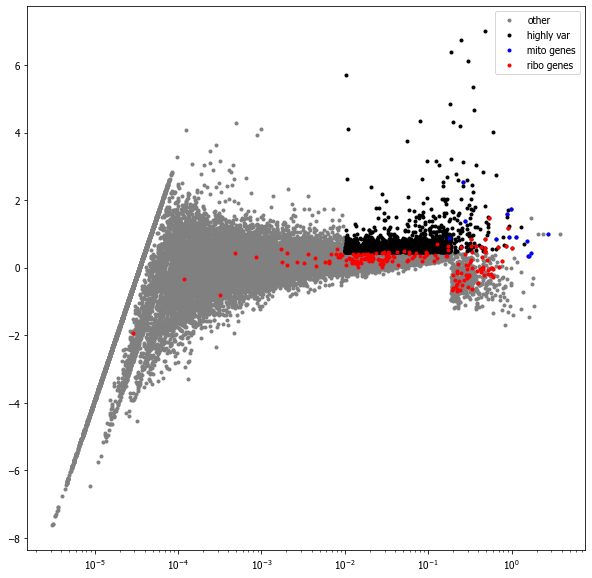

In [7]:
min_mean = 0.01# 0.01 #0.0005
max_mean = 1.5
min_disp = 0.5

sc.pp.highly_variable_genes(adata_merged)#,min_mean = min_mean,min_disp=min_disp,max_mean=max_mean)
top_ = sorted(adata_merged.var['dispersions_norm'][(adata_merged.var['means'] >= min_mean) & 
                                                      (adata_merged.var['means'] < max_mean)],
                  reverse=True)[2000]#[1000]
adata_merged.var['highly_variable'] = (adata_merged.var['dispersions_norm'] >= top_) \
& (adata_merged.var['means'] >= min_mean) & (adata_merged.var['means'] < max_mean)
adata_merged.var[adata_merged.var['highly_variable'] == True].sort_values(['means'],ascending=False)[0:50]
adata_merged.var[adata_merged.var['highly_variable'] == True].sort_values(['means'],ascending=True)[0:50]


plt.figure(figsize=(10,10))
plt.plot(adata_merged.var[adata_merged.var['highly_variable'] == False]['means'],adata_merged.var[adata_merged.var['highly_variable'] == False]['dispersions_norm'],'.',color='gray',label='other')
plt.plot(adata_merged.var[adata_merged.var['highly_variable'] == True]['means'],adata_merged.var[adata_merged.var['highly_variable'] == True]['dispersions_norm'],'.',color='black',label='highly var')
plt.plot(adata_merged.var.loc[mito_genes]['means'],adata_merged.var.loc[mito_genes]['dispersions_norm'],'.',color='blue',label='mito genes')
plt.plot(adata_merged.var.loc[rb_genes]['means'],adata_merged.var.loc[rb_genes]['dispersions_norm'],'.',color='red',label='ribo genes')
plt.xscale('log')
plt.legend()
plt.savefig('figures/'+line_+'/hvg.png')

In [8]:
org_markers = {}
vrg_markers = {}
with open('/project/elkabetz_lab_data/public_data/pollen_org_vrg_comp.tsv','r') as deseq_fn:
    for i,row in enumerate(deseq_fn):
        spl = row.strip("\n").split("\t")
        if i == 0: continue
        try:
            if float(spl[-1]) < 0.1:
                if abs(float(spl[1])) > 1:
                    if float(spl[1]) > 0:
                        org_markers[spl[0]] = float(spl[1])
                    else:
                        vrg_markers[spl[0]] = float(spl[1])
        except:
            pass

org_sepcific = []
vrg_specific = []
rg_general = []
org_de = []
vrg_de = []
with open('/project/elkabetz_lab_data/public_data/pollen_pca_analyses.tsv','r') as pca_fn:
    for i,row in enumerate(pca_fn):
        spl = row.strip("\n").split("\t")
        if spl[1] == 'ORG specificity': org_sepcific = spl[-1].strip(";").split(";")
        elif spl[1] == 'VRG specificity': vrg_specific = spl[-1].strip(";").split(";")
        elif spl[1] == 'General RG specificity': rg_general = spl[-1].strip(";").split(";")
        elif spl[1] == 'Up in ORG': org_de = spl[-1].strip(";").split(";")
        elif spl[1] == 'Up in VRG': vrg_de = spl[-1].strip(";").split(";")

vrg_genes = list(set(vrg_de).union(set(vrg_specific)).union(set(vrg_markers.keys())))
org_genes = list(set(org_de).union(set(org_sepcific)).union(set(org_markers.keys())))

adata_merged_nsc = adata_merged[adata_merged.obs['cell_type'].str.contains('Cortical')]#('Cortical NSC')]
adata_merged_nsc.obs['Index'] = range(len(adata_merged_nsc.obs))

Trying to set attribute `.obs` of view, copying.


In [9]:
bin_arr = adata_merged_nsc.X > 0
sum_dict = {}
n_cells_dict = {}
for clust in set(adata_merged_nsc.obs['louvain']):
    sum_ = np.sum(bin_arr[np.array(adata_merged_nsc.obs[adata_merged_nsc.obs['louvain'] == clust]['Index']),:],axis=0)
    n_cells = float(len(adata_merged_nsc.obs[adata_merged_nsc.obs['louvain'] == clust]))
    sum_dict[clust] = sum_
    n_cells_dict[clust] = n_cells

sub_iter_ = set([])
for j in range(len(sum_)):
    for clust in sum_dict.keys():
        if sum_dict[clust][j]/n_cells_dict[clust] > 0.02:
            sub_iter_.add(j)

sub_iter_ = sorted(list(sub_iter_))
adata_merged_nsc = adata_merged_nsc[:,sub_iter_]
org_genes_specific_sub = set(adata_merged_nsc.var.index).intersection(set(org_sepcific))

In [10]:
adata_merged_nsc.obs['louvain'] = adata_merged_nsc.obs['louvain'].astype('category')
adata_merged_nsc.obs['index'] = range(len(adata_merged_nsc.obs))
adata_merged_nsc.var['index'] = range(len(adata_merged_nsc.var))
clusts = set(adata_merged_nsc.obs['louvain'])

Trying to set attribute `.obs` of view, copying.


... storing 'tx' as categorical
... storing 'line' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_general' as categorical
... storing 'cell_type_clust' as categorical
... storing 'protocol' as categorical
... storing 'tx_line' as categorical


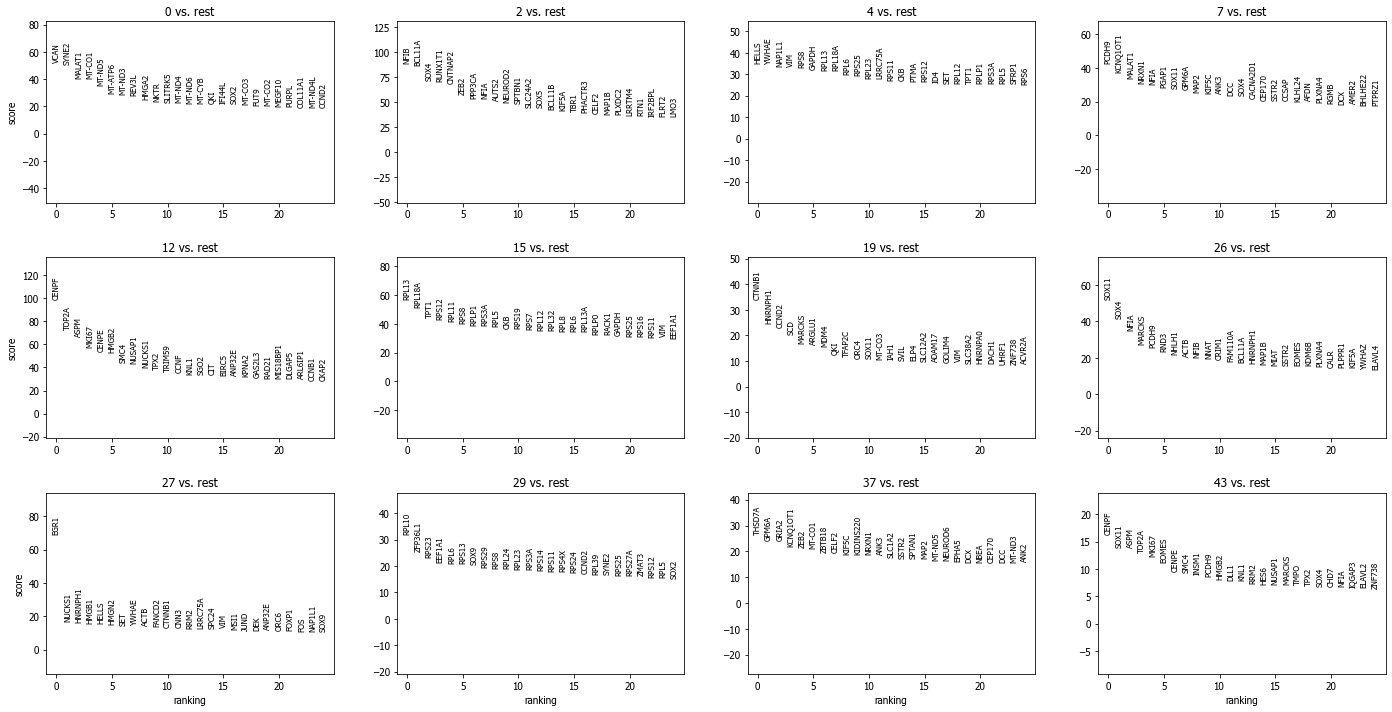

In [11]:
sc.tl.rank_genes_groups(adata_merged_nsc, 'louvain', method='t-test_overestim_var', n_genes=40000)
sc.pl.rank_genes_groups(adata_merged_nsc, n_genes=25, sharey=False)

In [12]:
#gene log fold changes
gene_log_fc = {}
clust_order = ['29','4','0','15','19','27','12','26','7','43','2','37']
sorted_genes = []
normed_vals = {}
for j,clust_iter in enumerate(clust_order):
    print(clust_iter)
    for gene in org_genes_specific_sub:
        normed_vals[gene] = {}
        gene_log_fc[gene] = {}
        expr_profiles = {}
        for clust in clust_order:
            expr_profiles[clust] = np.mean(adata_merged_nsc.X[adata_merged_nsc.obs[adata_merged_nsc.obs['louvain']==int(clust)]['index'],adata_merged_nsc.var.loc[gene]['index']])
        log_fc = []
        for clust in clust_order:
            log_fc.append((expr_profiles[clust]-min(expr_profiles.values()))/(max(expr_profiles.values())-min(expr_profiles.values())))
            normed_vals[gene][clust] = (expr_profiles[clust]-min(expr_profiles.values()))/(max(expr_profiles.values())-min(expr_profiles.values()))
        gene_log_fc[gene] = log_fc
        sorted_genes.extend([x[0] for x in sorted(gene_log_fc.items(),key=lambda x:x[1][j],reverse=True) if x[1][j] ==1 and x[0] not in sorted_genes])

29
4
0
15
19
27
12
26
7
43
2
37


In [13]:
cell_type_dict = {}
for clust,cell_type in zip(adata_merged.obs['louvain'],adata_merged.obs['cell_type']):
    cell_type_dict[clust]=cell_type

/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


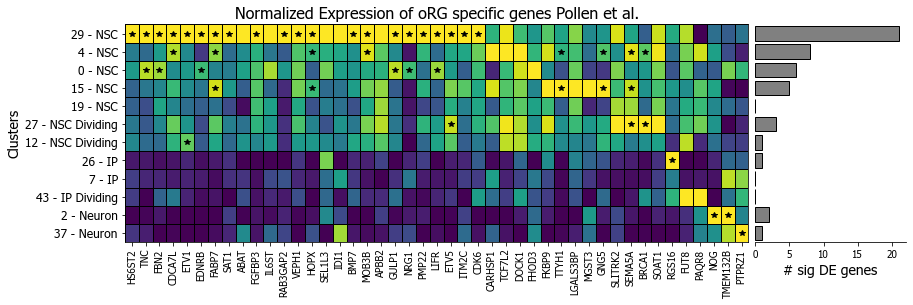

In [14]:
colormap = cm.viridis#coolwarm
normed_cmap = Normalize(vmin=0, vmax=1)
fig = plt.figure(figsize=(14,4))
ax = plt.subplot(111)
gs = gridspec.GridSpec(10,20,wspace=0.2, hspace=0.2)
ax = plt.subplot(gs[:,:16])

n_sig_by_clust = {}
for clust in clust_order: 
    n_sig_by_clust[clust] = 0

for j,gene in enumerate(sorted_genes):#clust_dict:#[clust_dict_r[x] for x in [1,2,3,4,5]]:
    for k,clust in enumerate(clust_order):
        val = normed_vals[gene][clust]
        color = tuple(np.array(colormap(normed_cmap(val),bytes=True))/255.)
        p = patches.Rectangle((j-1/2.,-k-1/2.), 1, 1, fill=True, 
                                  facecolor=color, linestyle='-',edgecolor='black')
        ax.add_patch(p)
        gene_idx = list(adata_merged_nsc.uns['rank_genes_groups']['names'][clust]).index(gene)
        if adata_merged_nsc.uns['rank_genes_groups']['pvals_adj'][clust][gene_idx] < 0.1 and \
        adata_merged_nsc.uns['rank_genes_groups']['logfoldchanges'][clust][gene_idx] > 1:
            plt.plot(j,-k,'*',color='k')
            n_sig_by_clust[clust]+=1

plt.xlim(-0.5,j+0.5)
plt.ylim(-k-0.5,0.5)
plt.ylabel('Clusters',fontsize=14)
plt.xticks(range(len(sorted_genes)),sorted_genes,fontsize=10,rotation=90)
plt.yticks(range(0,-len(clust_order),-1),[str(clust)+' - '+cell_type_dict[int(clust)].replace('Cortical ','') for clust in clust_order],fontsize=12)
plt.tight_layout()
plt.title('Normalized Expression of oRG specific genes Pollen et al.',fontsize=16)

ax = plt.subplot(gs[:,16:])
for k,clust in enumerate(clust_order):
    plt.barh(-k,n_sig_by_clust[clust],color='gray',edgecolor='black')

plt.ylim(-k-0.5,0.5)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.yticks([])
plt.xlabel('# sig DE genes',fontsize=14)
plt.savefig('figures/'+line_+'/pollen_matrix_plot.png',dpi=500,bbox_inches='tight')

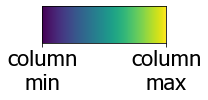

In [15]:
plt.figure(figsize=(3,1.5))
ax=plt.subplot(111)
max_y=255
min_val,max_val = 0,1
for j,val in enumerate(np.linspace(min_val,max_val,max_y)):
    color = tuple(np.array(colormap(normed_cmap(val),bytes=True))/255.)
    p = patches.Rectangle((j,0), 1, 1, fill=True, facecolor=color, linestyle='-',edgecolor=color)
    ax.add_patch(p)

plt.ylim(0,1)
plt.xticks(np.linspace(0,max_y,2),['column\nmin','column\nmax'],fontsize=22)
plt.xlabel('')
plt.yticks([])
plt.tight_layout()
plt.savefig('figures/'+line_+'/pollen_matrix_plot.legend.png',bbox_inches='tight',dpi=500)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
... storing 'tx' as categorical
... storing 'line' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_general' as categorical
... storing 'cell_type_clust' as categorical
... storing 'protocol' as categorical
... storing 'tx_line' as categorical


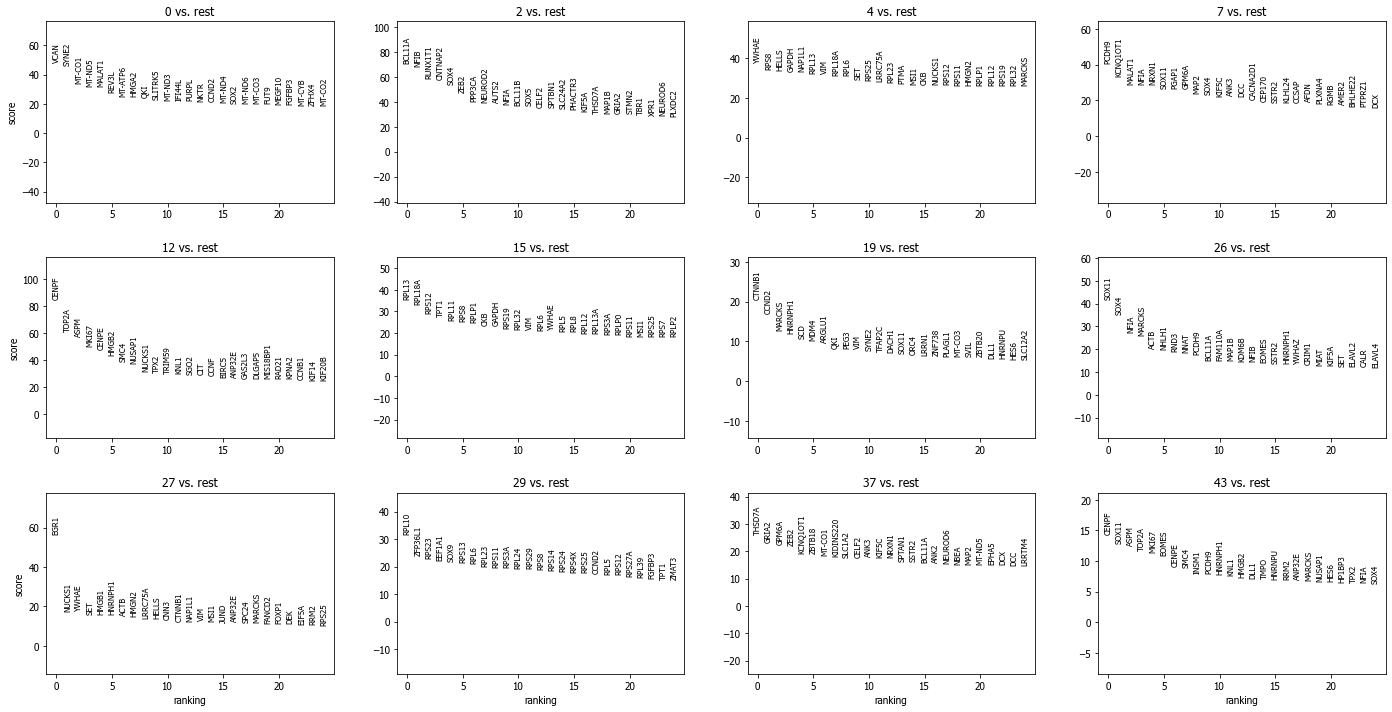

29
4
0
15
19
27
12
26
7
43
2
37


/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
... storing 'tx' as categorical
... storing 'line' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_general' as categorical
... storing 'cell_type_clust' as categorical
... storing 'protocol' as categorical
... storing 'tx_line' as categorical


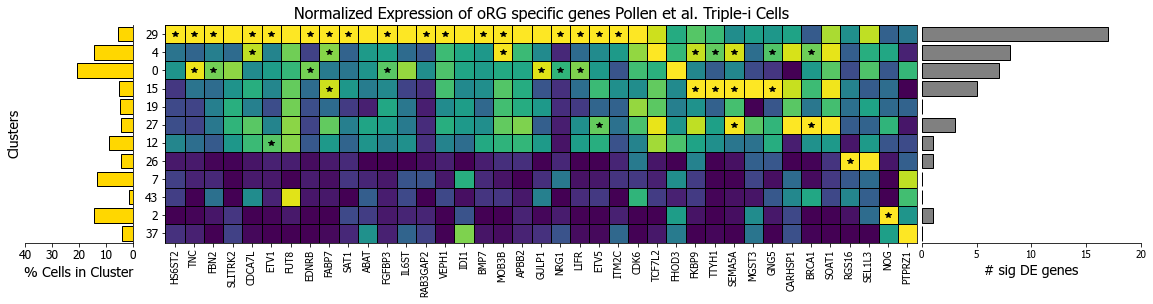

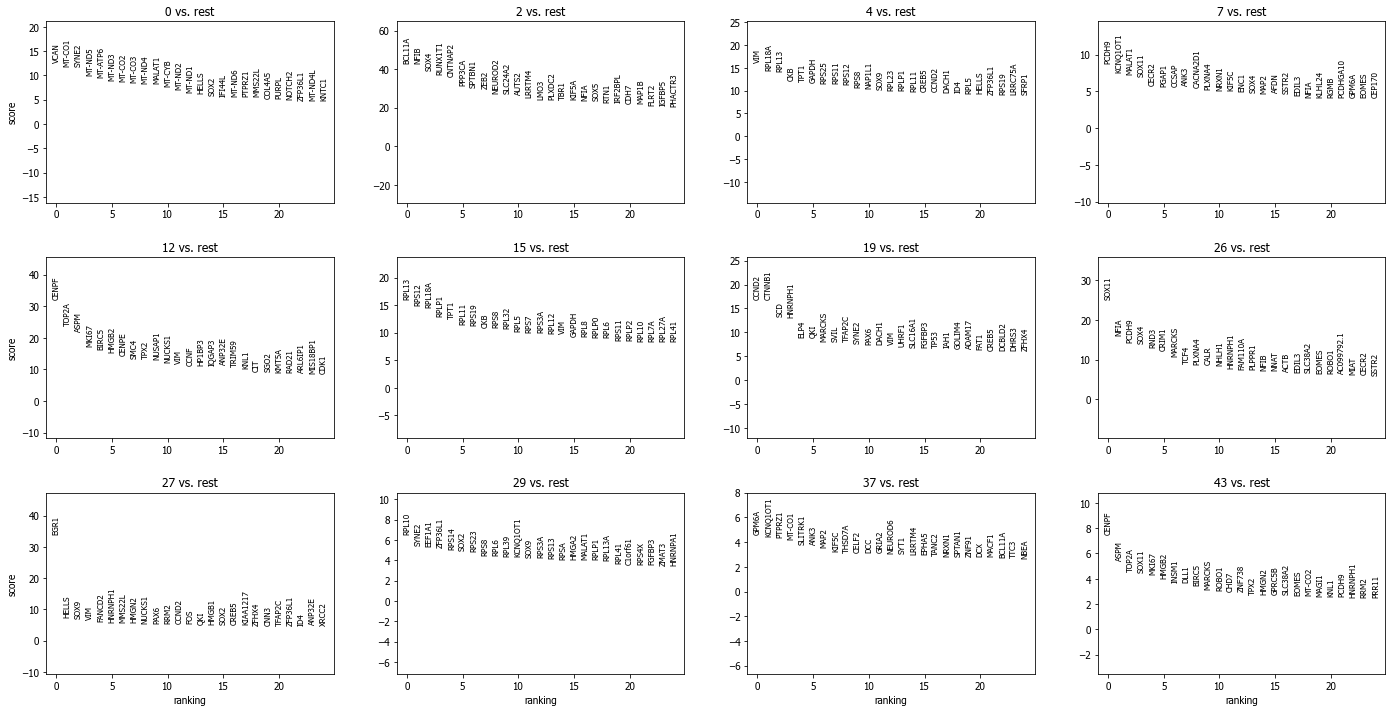

29
4
0
15
19
27
12
26
7
43
2
37


/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
... storing 'tx' as categorical
... storing 'line' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_general' as categorical
... storing 'cell_type_clust' as categorical
... storing 'protocol' as categorical
... storing 'tx_line' as categorical


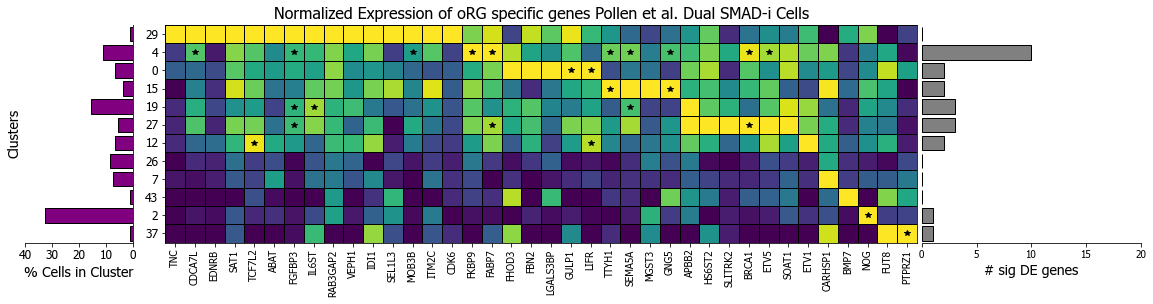

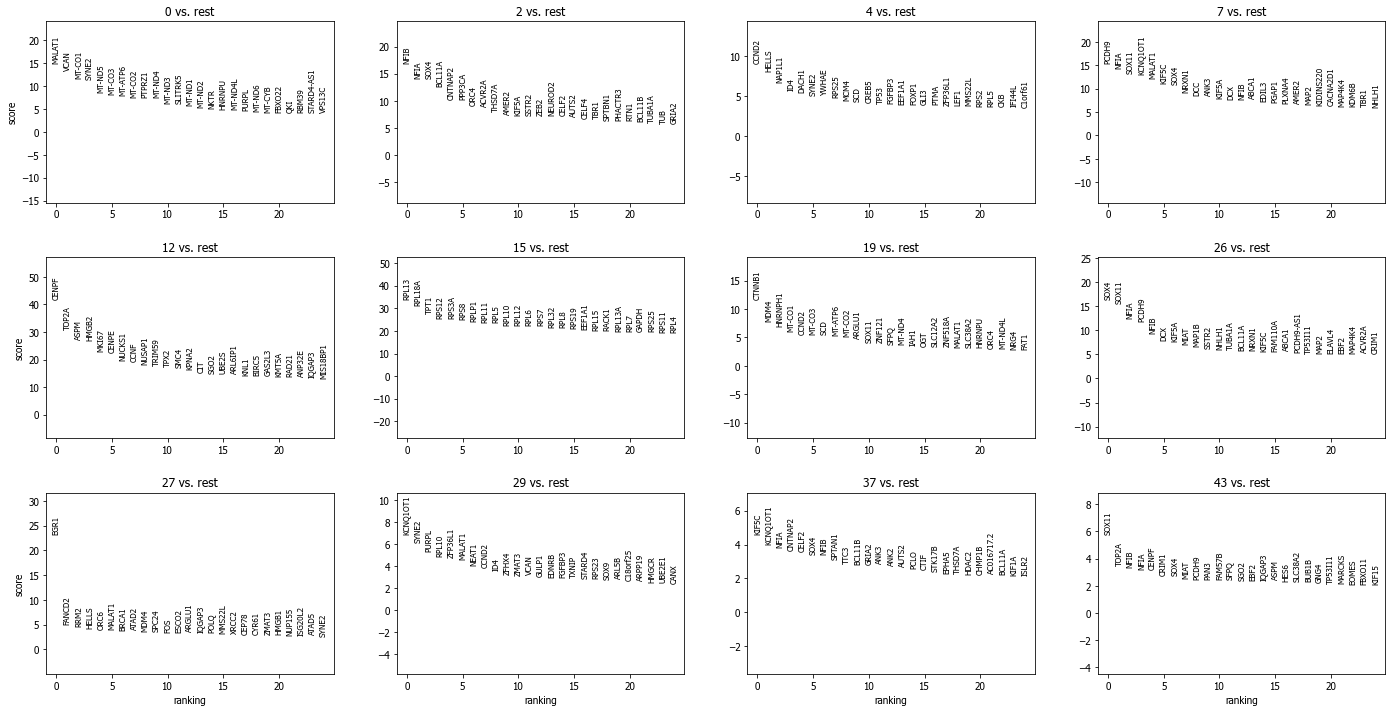

29
4
0
15
19
27
12
26
7
43
2
37


/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


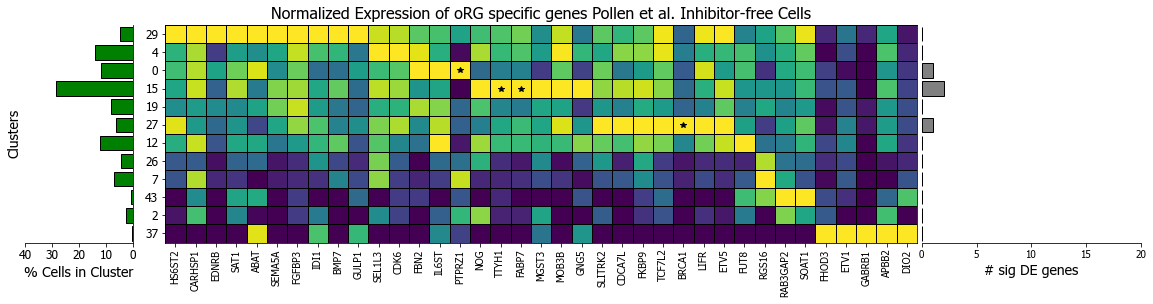

In [16]:
color_d = {'sbnx':'gold','sbn':'purple','nt':'green'}
tx_dict = {'sbnx':'Triple-i','sbn':'Dual SMAD-i','nt':'Inhibitor-free'}
for tx_iter in ['sbnx','sbn','nt']:
    adata_merged_nsc = adata_merged[(adata_merged.obs['cell_type'].str.contains('Cortical')) & (adata_merged.obs['tx']==tx_iter)]#('Cortical NSC')]
    adata_merged_nsc.obs['Index'] = range(len(adata_merged_nsc.obs))
    bin_arr = adata_merged_nsc.X > 0
    sum_dict = {}
    n_cells_dict = {}
    for clust in set(adata_merged_nsc.obs['louvain']):
        sum_ = np.sum(bin_arr[np.array(adata_merged_nsc.obs[adata_merged_nsc.obs['louvain'] == clust]['Index']),:],axis=0)
        n_cells = float(len(adata_merged_nsc.obs[adata_merged_nsc.obs['louvain'] == clust]))
        sum_dict[clust] = sum_
        n_cells_dict[clust] = n_cells
    sub_iter_ = set([])
    for j in range(len(sum_)):
        for clust in sum_dict.keys():
            if sum_dict[clust][j]/n_cells_dict[clust] > 0.05:
                sub_iter_.add(j)
    sub_iter_ = sorted(list(sub_iter_))
    adata_merged_nsc = adata_merged_nsc[:,sub_iter_]
    org_genes_specific_sub = set(adata_merged_nsc.var.index).intersection(set(org_sepcific))
    adata_merged_nsc.obs['louvain'] = adata_merged_nsc.obs['louvain'].astype('category')
    adata_merged_nsc.obs['index'] = range(len(adata_merged_nsc.obs))
    adata_merged_nsc.var['index'] = range(len(adata_merged_nsc.var))
    clusts = set(adata_merged_nsc.obs['louvain'])
    sc.tl.rank_genes_groups(adata_merged_nsc, 'louvain', method='t-test_overestim_var', n_genes=40000)
    sc.pl.rank_genes_groups(adata_merged_nsc, n_genes=25, sharey=False)
    gene_log_fc = {}
    clust_order = ['29','4','0','15','19','27','12','26','7','43','2','37']
    sorted_genes = []
    normed_vals = {}
    for j,clust_iter in enumerate(clust_order):
        print(clust_iter)
        for gene in org_genes_specific_sub:
            normed_vals[gene] = {}
            gene_log_fc[gene] = {}
            expr_profiles = {}
            for clust in clust_order:
                expr_profiles[clust] = np.mean(adata_merged_nsc.X[adata_merged_nsc.obs[adata_merged_nsc.obs['louvain']==int(clust)]['index'],adata_merged_nsc.var.loc[gene]['index']])
            log_fc = []
            for clust in clust_order:
                log_fc.append((expr_profiles[clust]-min(expr_profiles.values()))/(max(expr_profiles.values())-min(expr_profiles.values())))
                normed_vals[gene][clust] = (expr_profiles[clust]-min(expr_profiles.values()))/(max(expr_profiles.values())-min(expr_profiles.values()))
            gene_log_fc[gene] = log_fc
            sorted_genes.extend([x[0] for x in sorted(gene_log_fc.items(),key=lambda x:x[1][j],reverse=True) if x[1][j] ==1 and x[0] not in sorted_genes])
    cell_type_dict = {}
    for clust,cell_type in zip(adata_merged.obs['louvain'],adata_merged.obs['cell_type']):
        cell_type_dict[clust]=cell_type
    colormap = cm.viridis#coolwarm
    normed_cmap = Normalize(vmin=0, vmax=1)
    fig = plt.figure(figsize=(20,4))
    ax = plt.subplot(111)
    gs = gridspec.GridSpec(10,40,wspace=0.2, hspace=0.2)
    ax = plt.subplot(gs[:,:4])
    for k,clust in enumerate(clust_order):
        plt.barh(-k,-len(adata_merged_nsc.obs[(adata_merged_nsc.obs['louvain']==int(clust)) & (adata_merged_nsc.obs['tx']==tx_iter)])/
            len(adata_merged_nsc.obs[(adata_merged_nsc.obs['tx']==tx_iter)]),color=color_d[tx_iter],edgecolor='black')
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.ylabel('Clusters',fontsize=14)
    plt.xlabel('% Cells in Cluster',fontsize=14)
    plt.xlim(-0.4,0)
    plt.ylim(-k-0.5,0.5)
    plt.xticks([-.4,-.3,-.2,-.1,0],['40','30','20','10','0'],fontsize=12)
    plt.yticks([])
    ax = plt.subplot(gs[:,5:32])
    n_sig_by_clust = {}
    for clust in clust_order: 
        n_sig_by_clust[clust] = 0
    for j,gene in enumerate(sorted_genes):#clust_dict:#[clust_dict_r[x] for x in [1,2,3,4,5]]:
        for k,clust in enumerate(clust_order):
            val = normed_vals[gene][clust]
            color = tuple(np.array(colormap(normed_cmap(val),bytes=True))/255.)
            p = patches.Rectangle((j-1/2.,-k-1/2.), 1, 1, fill=True, 
                                      facecolor=color, linestyle='-',edgecolor='black')
            ax.add_patch(p)
            gene_idx = list(adata_merged_nsc.uns['rank_genes_groups']['names'][clust]).index(gene)
            if adata_merged_nsc.uns['rank_genes_groups']['pvals_adj'][clust][gene_idx] < 0.1 and \
            adata_merged_nsc.uns['rank_genes_groups']['logfoldchanges'][clust][gene_idx] > 1:
                plt.plot(j,-k,'*',color='k')
                n_sig_by_clust[clust]+=1
    plt.xlim(-0.5,j+0.5)
    plt.ylim(-k-0.5,0.5)
    plt.xticks(range(len(sorted_genes)),sorted_genes,fontsize=10,rotation=90)
    plt.yticks(range(0,-len(clust_order),-1),[str(clust) for clust in clust_order],fontsize=12)
    plt.tight_layout()
    plt.title('Normalized Expression of oRG specific genes Pollen et al. '+tx_dict[tx_iter]+' Cells',fontsize=16)
    ax = plt.subplot(gs[:,32:])
    for k,clust in enumerate(clust_order):
        plt.barh(-k,n_sig_by_clust[clust],color='gray',edgecolor='black')
    plt.ylim(-k-0.5,0.5)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.yticks([])
    plt.xlim(0,20)
    plt.xticks([0,5,10,15,20],[0,5,10,15,20])
    plt.xlabel('# sig DE genes',fontsize=14)
    plt.savefig('figures/'+line_+'/pollen_matrix_plot.'+tx_iter+'.png',dpi=500,bbox_inches='tight')

Trying to set attribute `.obs` of view, copying.
/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'tx' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'line' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_general' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_clust' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'protocol' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'tx_line' as categorical


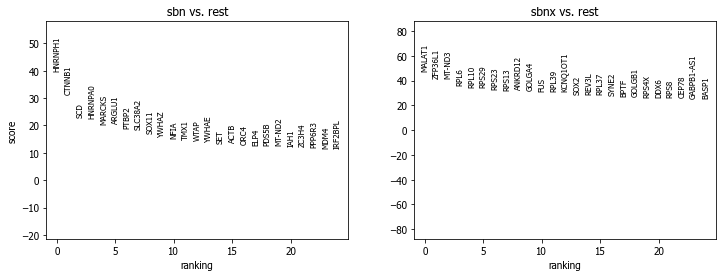

/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log


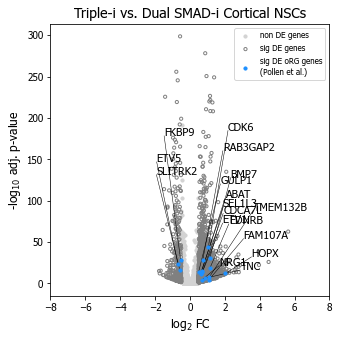

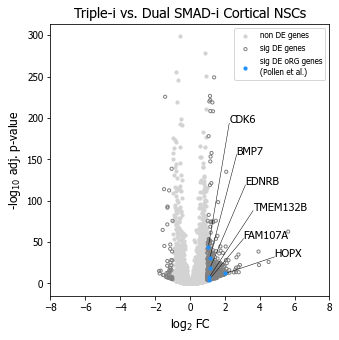

In [17]:
adata_merged_nsc = adata_merged[(adata_merged.obs['cell_type'].str.contains('Cortical NSC')) & (adata_merged.obs['tx'].isin(['sbnx','sbn']))]
adata_merged_nsc.obs['Index'] = range(len(adata_merged_nsc.obs))
bin_arr = adata_merged_nsc.X > 0
sum1 = np.sum(bin_arr[np.array(adata_merged_nsc.obs[adata_merged_nsc.obs['tx'] == 'sbnx']['Index']),:],axis=0)
sum2 = np.sum(bin_arr[np.array(adata_merged_nsc.obs[adata_merged_nsc.obs['tx'] == 'sbn']['Index']),:],axis=0)
n_cells1 = float(len(adata_merged_nsc.obs[adata_merged_nsc.obs['tx'] == 'sbnx']))
n_cells2 = float(len(adata_merged_nsc.obs[adata_merged_nsc.obs['tx'] == 'sbn']))
adata_merged_nsc = adata_merged_nsc[:,(sum1/n_cells1 > 0.01) | (sum2/n_cells2 > 0.01)]

sc.tl.rank_genes_groups(adata_merged_nsc, 'tx', method='t-test_overestim_var',n_genes=40000)#'t-test_overestim_var', n_genes=40000)
sc.pl.rank_genes_groups(adata_merged_nsc, n_genes=25, sharey=False)
genes = adata_merged_nsc.uns['rank_genes_groups']['names'][0]
genes_idx_dict = {}
for j,gene in enumerate(adata_merged_nsc.var.index): 
    genes_idx_dict[gene] = j

fishers_exact = {}
for log_fc_cutoff in [0.5,1.0]:
    fishers_exact[log_fc_cutoff] = {}
    pct_cutoff = 0.05
    perc_diff_cutoff = 0.05
    pval_cutoff = 0.1
    adata_merged_nsc.obs['Index'] = range(len(adata_merged_nsc.obs))
    bin_arr = adata_merged_nsc.X > 0
    rg_comp = {}
    for clust in [str(y) for y in sorted([x for x in set(adata_merged_nsc.obs['tx'])])]:
        rg_comp[clust] = {}
        genes_ = adata_merged_nsc.uns['rank_genes_groups']['names'][clust]
        mean_expr = np.mean(adata_merged_nsc.X[np.array(adata_merged_nsc.obs[adata_merged_nsc.obs['tx'] ==clust]['Index']),:],axis=0)
        sum1 = np.sum(bin_arr[np.array(adata_merged_nsc.obs[adata_merged_nsc.obs['tx'] == clust]['Index']),:],axis=0)
        sum2 = np.sum(bin_arr[np.array(adata_merged_nsc.obs[adata_merged_nsc.obs['tx'] != clust]['Index']),:],axis=0)
        n_cells1 = float(len(adata_merged_nsc.obs[adata_merged_nsc.obs['tx'] == clust]))
        n_cells2 = float(len(adata_merged_nsc.obs[adata_merged_nsc.obs['tx'] != clust]))
        for j,gene in enumerate(genes_):
            logfc = adata_merged_nsc.uns['rank_genes_groups']['logfoldchanges'][clust][j]
            pval = adata_merged_nsc.uns['rank_genes_groups']['pvals'][clust][j]
            pval_adj = adata_merged_nsc.uns['rank_genes_groups']['pvals_adj'][clust][j]
            pct1 = sum1[genes_idx_dict[gene]]/n_cells1
            pct2 = sum2[genes_idx_dict[gene]]/n_cells2
            pct_diff = pct1 - pct2
            sig_ = 'FALSE'
            if pval_adj == 'na': sig_= 'FALSE'
            elif pval_adj < pval_cutoff and logfc > log_fc_cutoff and pct_diff > perc_diff_cutoff: sig_= 'TRUE'
            elif pval_adj < pval_cutoff and logfc < -log_fc_cutoff and pct_diff < -perc_diff_cutoff: sig_= 'TRUE'
            rg_comp[clust][gene] = {'log_fc':logfc,'pval':pval,'pval_adj':pval_adj,'pct.1':pct1,'pct.2':pct2,'mean_expr':mean_expr[genes_idx_dict[gene]]}
    gset_lab = {'org':'sig DE oRG genes\n(Pollen et al.)','sig_other':'sig DE genes','other':'non DE genes'}
    up_genes = set([])
    down_genes = set([])
    for clust in rg_comp:
        all_genes = set(rg_comp[clust].keys())
        if clust == 'sbnx':
            plt.figure(figsize=(5,5))
        xs = {'org':[],'sig_other':[],'other':[]}
        ys = {'org':[],'sig_other':[],'other':[]}
        gene_dict = {'org':[],'sig_other':[],'other':[]}
        for gene in rg_comp[clust]:
            log_fc = rg_comp[clust][gene]['log_fc']
            pval_adj = rg_comp[clust][gene]['pval_adj']
            if log_fc > log_fc_cutoff and pval_adj < pval_cutoff:
                up_genes.add(gene)
            elif log_fc < -log_fc_cutoff and pval_adj < pval_cutoff:
                down_genes.add(gene)
            if gene in org_sepcific and abs(log_fc) > log_fc_cutoff and pval_adj < pval_cutoff:# and abs(org_v_vrg[gene]['pct.1'] - org_v_vrg[gene]['pct.2']) > 0.02:
                xs['org'].append(log_fc)
                ys['org'].append(-np.log(pval_adj)/np.log(10))
                gene_dict['org'].append(gene)
                if clust == '1':
                    print(gene,rg_comp[clust][gene])
            elif abs(log_fc) > log_fc_cutoff and pval_adj < pval_cutoff:# and abs(org_v_vrg[gene]['pct.1'] - org_v_vrg[gene]['pct.2']) > 0.02:
                xs['sig_other'].append(log_fc)
                ys['sig_other'].append(-np.log(pval_adj)/np.log(10))
                gene_dict['sig_other'].append(gene)
            else:
                xs['other'].append(log_fc)
                ys['other'].append(-np.log(pval_adj)/np.log(10))
                gene_dict['other'].append(gene)
        fishers_exact[log_fc_cutoff]['up'] = [scipy.stats.fisher_exact([[len(up_genes.intersection(set(org_sepcific))),len(up_genes-set(org_sepcific))],
            [len((all_genes-up_genes).intersection(set(org_sepcific))),len(all_genes-up_genes-set(org_sepcific))]]),
            [len(up_genes.intersection(set(org_sepcific))),len(up_genes-set(org_sepcific))],
            [len((all_genes-up_genes).intersection(set(org_sepcific))),len(all_genes-up_genes-set(org_sepcific))]]
        colors = ['lightgray','gray','dodgerblue','gold']
        if clust == 'sbnx':
            for g_set,color in zip(['other','sig_other','org'],colors):
                if g_set == 'other':
                    plt.scatter([xs[g_set][i] for i in range(len(ys[g_set]))],
                            [ys[g_set][i] for i in range(len(ys[g_set]))],
                            s=10,alpha=1,facecolors=color,edgecolors=None,label=gset_lab[g_set])
                elif g_set == 'sig_other':
                    plt.scatter([xs[g_set][i] for i in range(len(ys[g_set]))],
                            [ys[g_set][i] for i in range(len(ys[g_set]))],
                            s=10,alpha=1,facecolors='None',edgecolors=color,label=gset_lab[g_set])
                else:
                    plt.scatter([xs[g_set][i] for i in range(len(ys[g_set]))],
                            [ys[g_set][i] for i in range(len(ys[g_set]))],
                            c=color,s=10,alpha=1,label=gset_lab[g_set],zorder=6)
                    if g_set == 'org':
                        thetas = {g_set:[]}
                        dist_orig_dict = {g_set:[]}
                        y_delta = np.linspace(0,150,len(ys[g_set])+1)
                        y_delta = y_delta[1:]
                        for x,y in zip(xs[g_set],ys[g_set]):
                            dist_orig = np.math.sqrt(x**2+(y*3)**2)
                            dist_orig_dict[g_set].append(dist_orig)
                            thetas[g_set].append(np.math.asin((y*3)/dist_orig))
                        for j,(x,y,gene_lab,theta,dist_orig) in enumerate(sorted(zip(xs[g_set],ys[g_set],gene_dict[g_set],thetas[g_set],dist_orig_dict[g_set]),
                            key=lambda x:x[3])):
                            if x < 0:
                                plt.annotate(gene_lab,xy=(x-np.math.cos(theta)*(y_delta[j]),y+y_delta[j]),fontsize=11)
                                plt.plot([x,x-np.math.cos(theta)*(y_delta[j])],[y,y+y_delta[j]],'-',color='black',linewidth=0.5,zorder=5)
                            elif gene_lab == 'FAM107A':
                                plt.annotate(gene_lab,xy=(x+2,y+50),fontsize=11)
                                plt.plot([x,x+2],[y,y+50],'-',color='black',linewidth=0.5,zorder=5)
                            elif gene_lab == 'TMEM132B':
                                plt.annotate(gene_lab,xy=(x+2.5,y+80),fontsize=11)
                                plt.plot([x,x+2.5],[y,y+80],'-',color='black',linewidth=0.5,zorder=5)
                            elif gene_lab == 'HOPX':
                                plt.annotate(gene_lab,xy=(x+np.math.cos(theta)*(y_delta[j]),y+20),fontsize=11)
                                plt.plot([x,x+np.math.cos(theta)*(y_delta[j])],[y,y+20],'-',color='black',linewidth=0.5,zorder=5)
                            elif gene_lab == 'TNC':
                                plt.annotate(gene_lab,xy=(x+np.math.cos(theta)*(y_delta[j]),y+10),fontsize=11)
                                plt.plot([x,x+np.math.cos(theta)*(y_delta[j])],[y,y+10],'-',color='black',linewidth=0.5,zorder=5)
                            else:
                                plt.annotate(gene_lab,xy=(x+np.math.cos(theta)*(y_delta[j]),y+y_delta[j]),fontsize=11)
                                plt.plot([x,x+np.math.cos(theta)*(y_delta[j])],[y,y+y_delta[j]],'-',color='black',linewidth=0.5,zorder=5)
            plt.legend(fontsize=8)
            plt.title('Triple-i vs. Dual SMAD-i Cortical NSCs',fontsize=14)
            plt.xlim(-8,8)
            plt.xlabel('log${_2}$ FC',fontsize=12)
            plt.ylabel('-log$_{10}$ adj. p-value',fontsize=12)
            plt.savefig('figures/'+line_+'/t-test.all_lines.sbnx_sbn.log_fc_cutoff_'+str(log_fc_cutoff)+'.png',dpi=500)
    n_up,n_down = 0,0
    for gene in rg_comp['sbnx']:
        if rg_comp['sbnx'][gene]['log_fc'] > log_fc_cutoff and rg_comp['sbnx'][gene]['pval_adj'] < pval_cutoff:
            n_up += 1
        if rg_comp['sbnx'][gene]['log_fc'] < -log_fc_cutoff and rg_comp['sbnx'][gene]['pval_adj'] < pval_cutoff:
            n_down += 1

In [18]:
fishers_exact

{0.5: {'up': [(1.0619407474246183, 0.8789954668752593),
   [17, 3432],
   [31, 6646]]},
 1.0: {'up': [(2.3139931740614332, 0.059415271548625054),
   [6, 586],
   [42, 9492]]}}

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
... storing 'tx' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'line' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_general' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_clust' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'protocol' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'tx_line' as categorical


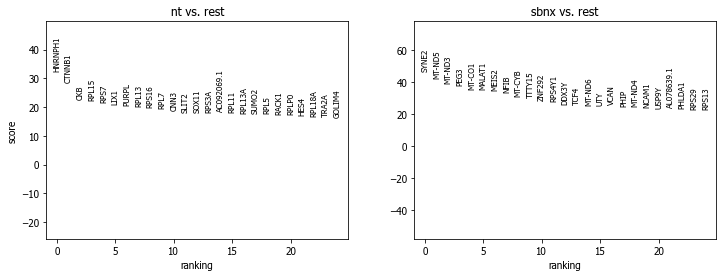

nt
sbnx


/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


nt
sbnx


/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log


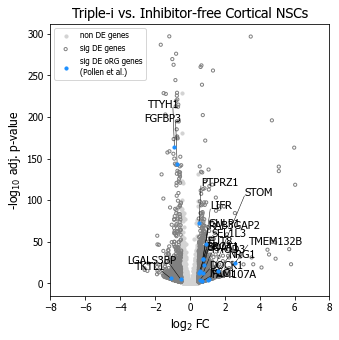

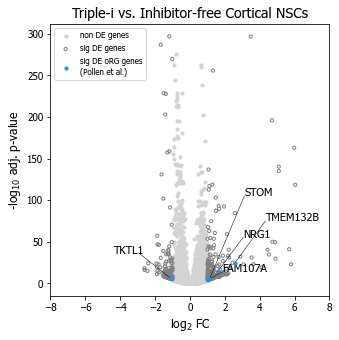

In [19]:
adata_merged_nsc = adata_merged[(adata_merged.obs['cell_type'].str.contains('Cortical NSC')) & (adata_merged.obs['tx'].isin(['sbnx','nt']))]
adata_merged_nsc.obs['Index'] = range(len(adata_merged_nsc.obs))
bin_arr = adata_merged_nsc.X > 0
sum1 = np.sum(bin_arr[np.array(adata_merged_nsc.obs[adata_merged_nsc.obs['tx'] == 'sbnx']['Index']),:],axis=0)
sum2 = np.sum(bin_arr[np.array(adata_merged_nsc.obs[adata_merged_nsc.obs['tx'] == 'nt']['Index']),:],axis=0)
n_cells1 = float(len(adata_merged_nsc.obs[adata_merged_nsc.obs['tx'] == 'sbnx']))
n_cells2 = float(len(adata_merged_nsc.obs[adata_merged_nsc.obs['tx'] == 'nt']))
adata_merged_nsc = adata_merged_nsc[:,(sum1/n_cells1 > 0.01) | (sum2/n_cells2 > 0.01)]

sc.tl.rank_genes_groups(adata_merged_nsc, 'tx', method='t-test_overestim_var',n_genes=40000)#'t-test_overestim_var', n_genes=40000)
sc.pl.rank_genes_groups(adata_merged_nsc, n_genes=25, sharey=False)
genes = adata_merged_nsc.uns['rank_genes_groups']['names'][0]
genes_idx_dict = {}
for j,gene in enumerate(adata_merged_nsc.var.index): 
    genes_idx_dict[gene] = j

fishers_exact = {}
for log_fc_cutoff in [0.5,1.0]:
    fishers_exact[log_fc_cutoff] = {}
    pct_cutoff = 0.05
    perc_diff_cutoff = 0.05
    pval_cutoff = 0.1
    adata_merged_nsc.obs['Index'] = range(len(adata_merged_nsc.obs))
    bin_arr = adata_merged_nsc.X > 0
    rg_comp = {}
    for clust in [str(y) for y in sorted([x for x in set(adata_merged_nsc.obs['tx'])])]:
        rg_comp[clust] = {}
        print(clust)
        genes_ = adata_merged_nsc.uns['rank_genes_groups']['names'][clust]
        mean_expr = np.mean(adata_merged_nsc.X[np.array(adata_merged_nsc.obs[adata_merged_nsc.obs['tx'] ==clust]['Index']),:],axis=0)
        sum1 = np.sum(bin_arr[np.array(adata_merged_nsc.obs[adata_merged_nsc.obs['tx'] == clust]['Index']),:],axis=0)
        sum2 = np.sum(bin_arr[np.array(adata_merged_nsc.obs[adata_merged_nsc.obs['tx'] != clust]['Index']),:],axis=0)
        n_cells1 = float(len(adata_merged_nsc.obs[adata_merged_nsc.obs['tx'] == clust]))
        n_cells2 = float(len(adata_merged_nsc.obs[adata_merged_nsc.obs['tx'] != clust]))
        for j,gene in enumerate(genes_):
            logfc = adata_merged_nsc.uns['rank_genes_groups']['logfoldchanges'][clust][j]
            pval = adata_merged_nsc.uns['rank_genes_groups']['pvals'][clust][j]
            pval_adj = adata_merged_nsc.uns['rank_genes_groups']['pvals_adj'][clust][j]
            pct1 = sum1[genes_idx_dict[gene]]/n_cells1
            pct2 = sum2[genes_idx_dict[gene]]/n_cells2
            pct_diff = pct1 - pct2
            sig_ = 'FALSE'
            if pval_adj == 'na': sig_= 'FALSE'
            elif pval_adj < pval_cutoff and logfc > log_fc_cutoff and pct_diff > perc_diff_cutoff: sig_= 'TRUE'
            elif pval_adj < pval_cutoff and logfc < -log_fc_cutoff and pct_diff < -perc_diff_cutoff: sig_= 'TRUE'
            rg_comp[clust][gene] = {'log_fc':logfc,'pval':pval,'pval_adj':pval_adj,'pct.1':pct1,'pct.2':pct2,'mean_expr':mean_expr[genes_idx_dict[gene]]}
    gset_lab = {'org':'sig DE oRG genes\n(Pollen et al.)','sig_other':'sig DE genes','other':'non DE genes'}
    for clust in rg_comp:
        up_genes = set([])
        down_genes = set([])
        if clust == 'sbnx':
            plt.figure(figsize=(5,5))
        xs = {'org':[],'sig_other':[],'other':[]}
        ys = {'org':[],'sig_other':[],'other':[]}
        gene_dict = {'org':[],'sig_other':[],'other':[]}
        for gene in rg_comp[clust]:
            log_fc = rg_comp[clust][gene]['log_fc']
            pval_adj = rg_comp[clust][gene]['pval_adj']
            if log_fc > log_fc_cutoff and pval_adj < pval_cutoff:
                up_genes.add(gene)
            elif log_fc < -log_fc_cutoff and pval_adj < pval_cutoff:
                down_genes.add(gene)
            if gene in org_sepcific and abs(log_fc) > log_fc_cutoff and pval_adj < pval_cutoff:
                xs['org'].append(log_fc)
                ys['org'].append(-np.log(pval_adj)/np.log(10))
                gene_dict['org'].append(gene)
                if clust == '1':
                    print(gene,rg_comp[clust][gene])
            elif abs(log_fc) > log_fc_cutoff and pval_adj < pval_cutoff:
                xs['sig_other'].append(log_fc)
                ys['sig_other'].append(-np.log(pval_adj)/np.log(10))
                gene_dict['sig_other'].append(gene)
            else:
                xs['other'].append(log_fc)
                ys['other'].append(-np.log(pval_adj)/np.log(10))
                gene_dict['other'].append(gene)
        fishers_exact[log_fc_cutoff]['up'] = [scipy.stats.fisher_exact([[len(up_genes.intersection(set(org_sepcific))),len(up_genes-set(org_sepcific))],
            [len((all_genes-up_genes).intersection(set(org_sepcific))),len(all_genes-up_genes-set(org_sepcific))]]),
            [len(up_genes.intersection(set(org_sepcific))),len(up_genes-set(org_sepcific))],
            [len((all_genes-up_genes).intersection(set(org_sepcific))),len(all_genes-up_genes-set(org_sepcific))]]
        colors = ['lightgray','gray','dodgerblue','gold']
        for g_set,color in zip(['other','sig_other','org'],colors):
            if clust == 'sbnx':
                if g_set == 'other':
                    plt.scatter([xs[g_set][i] for i in range(len(ys[g_set]))],
                            [ys[g_set][i] for i in range(len(ys[g_set]))],
                            s=10,alpha=1,facecolors=color,edgecolors=None,label=gset_lab[g_set])
                elif g_set == 'sig_other':
                    plt.scatter([xs[g_set][i] for i in range(len(ys[g_set]))],
                            [ys[g_set][i] for i in range(len(ys[g_set]))],
                            s=10,alpha=1,facecolors='None',edgecolors=color,label=gset_lab[g_set])
                else:
                    plt.scatter([xs[g_set][i] for i in range(len(ys[g_set]))],
                            [ys[g_set][i] for i in range(len(ys[g_set]))],
                            c=color,s=10,alpha=1,label=gset_lab[g_set],zorder=6)
                    if g_set == 'org':
                        thetas = {g_set:[]}
                        dist_orig_dict = {g_set:[]}
                        y_delta = np.linspace(0,50,len(ys[g_set])+1)
                        y_delta = y_delta[1:]
                        for x,y in zip(xs[g_set],ys[g_set]):
                            dist_orig = np.math.sqrt(x**2+(y*3)**2)
                            dist_orig_dict[g_set].append(dist_orig)
                            thetas[g_set].append(np.math.asin((y*3)/dist_orig))
                        for j,(x,y,gene_lab,theta,dist_orig) in enumerate(sorted(zip(xs[g_set],ys[g_set],gene_dict[g_set],thetas[g_set],dist_orig_dict[g_set]),
                            key=lambda x:x[3])):
                            if x < 0:
                                plt.annotate(gene_lab,xy=(x-np.math.cos(theta)*(y_delta[j])-len(gene_lab)*0.3,y+y_delta[j]),fontsize=11)
                                plt.plot([x,x-np.math.cos(theta)*(y_delta[j])],[y,y+y_delta[j]],'-',color='black',linewidth=0.5,zorder=5)
                            elif gene_lab == 'STOM':
                                plt.annotate(gene_lab,xy=(x+2,y+100),fontsize=11)
                                plt.plot([x,x+2],[y,y+100],'-',color='black',linewidth=0.5,zorder=5)
                            else:
                                plt.annotate(gene_lab,xy=(x+np.math.cos(theta)*(y_delta[j]),y+y_delta[j]),fontsize=11)
                                plt.plot([x,x+np.math.cos(theta)*(y_delta[j])],[y,y+y_delta[j]],'-',color='black',linewidth=0.5,zorder=5)
                plt.legend(fontsize=8)
                plt.title('Triple-i vs. Inhibitor-free Cortical NSCs',fontsize=14)
                plt.xlim(-8,8)
                plt.xlabel('log${_2}$ FC',fontsize=12)
                plt.ylabel('-log$_{10}$ adj. p-value',fontsize=12)
                plt.savefig('figures/'+line_+'/t-test.all_lines.sbnx_nt.log_fc_cutoff_'+str(log_fc_cutoff)+'.png',dpi=500)
    n_up,n_down = 0,0
    for gene in rg_comp['sbnx']:
        if rg_comp['sbnx'][gene]['log_fc'] > log_fc_cutoff and rg_comp['sbnx'][gene]['pval_adj'] < pval_cutoff:
            n_up += 1
        if rg_comp['sbnx'][gene]['log_fc'] < -log_fc_cutoff and rg_comp['sbnx'][gene]['pval_adj'] < pval_cutoff:
            n_down += 1

In [20]:
fishers_exact

{0.5: {'up': [(2.2212192013593883, 0.01861115746915831),
   [15, 1712],
   [33, 8366]]},
 1.0: {'up': [(4.0925695309256955, 0.02091514894032954),
   [4, 219],
   [44, 9859]]}}

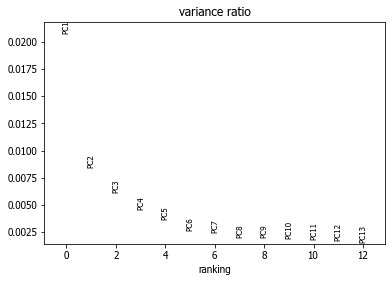

In [21]:
adata_merged.raw_X = copy.deepcopy(adata_merged.X)
sc.pp.scale(adata_merged,max_value=5)
adata_merged.scaled_5 = copy.deepcopy(adata_merged.X)

sc.tl.pca(adata_merged, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_merged, log=False, n_pcs=12, save=True)

sc.pp.neighbors(adata_merged,n_neighbors=30)#30)#20)##6)12)
sc.tl.umap(adata_merged,min_dist=0.5)#0.4)#0.1)

In [22]:
adata_merged.obs

,n_counts,n_genes,percent_mito,percent_ribo,tx,line,batch,Index,scrublet_doublet,doublet_score,louvain_old,louvain,cell_type,cell_type_general,index,cell_type_clust,protocol,tx_line
AAACCCACACCAATTG-1-0,2085.0,1141,0.080576,0.015348,sbnx,zip13k5,0,0,False,0.092035,3,37,Cortical Neuron,Cortical Neuron,0,Cortical Neuron (37),Triple-i,sbnx_zip13k5
AAACCCACATGGCACC-1-0,528.0,361,0.151515,0.032197,sbnx,zip13k5,0,1,False,0.032060,2,0,Cortical NSC,Cortical NSC,1,Cortical NSC (0),Triple-i,sbnx_zip13k5
AAACCCAGTCATATGC-1-0,1671.0,1027,0.137642,0.016756,sbnx,zip13k5,0,3,False,0.040888,2,0,Cortical NSC,Cortical NSC,3,Cortical NSC (0),Triple-i,sbnx_zip13k5
AAACCCATCATGCTAG-1-0,1888.0,1110,0.109640,0.027542,sbnx,zip13k5,0,4,False,0.078247,2,0,Cortical NSC,Cortical NSC,4,Cortical NSC (0),Triple-i,sbnx_zip13k5
AAACGAAAGTAATACG-1-0,557.0,409,0.157989,0.026930,sbnx,zip13k5,0,6,False,0.088260,18,12,Cortical NSC Dividing,Cortical NSC,6,Cortical NSC Dividing (12),Triple-i,sbnx_zip13k5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGCTGCCAAATGGTA-1-9,800.0,573,0.013750,0.067500,sbn,KUCG2,1,96099,False,0.049576,21,12,Cortical NSC Dividing,Cortical NSC,96099,Cortical NSC Dividing (12),Dual SMAD-i,sbn_KUCG2
TTTACTGAGGTTACCT-1-9,527.0,382,0.110057,0.034156,sbn,KUCG2,1,96273,False,0.041633,2,0,Cortical NSC,Cortical NSC,96273,Cortical NSC (0),Dual SMAD-i,sbn_KUCG2
TTTCAGTGTCGAGCAA-1-9,610.0,465,0.016393,0.073770,sbn,KUCG2,1,96332,False,0.198946,11,26,Cortical IP,Cortical IP,96332,Cortical IP (26),Dual SMAD-i,sbn_KUCG2
TTTCCTCTCTGTACAG-1-9,955.0,683,0.006283,0.105759,sbn,KUCG2,1,96360,False,0.050863,8,15,Cortical NSC,Cortical NSC,96360,Cortical NSC (15),Dual SMAD-i,sbn_KUCG2


/project/elkabetz_lab/Daniel/zeus/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


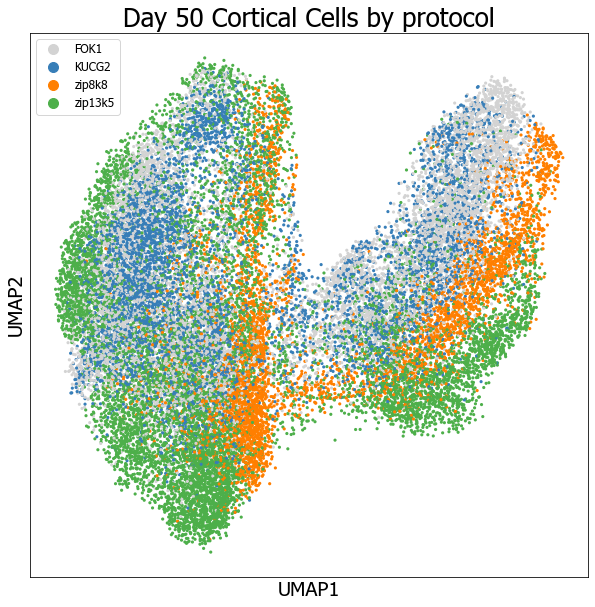

In [23]:
## overall fig
fig = plt.figure(figsize=(10,10))
clrs = sns.color_palette('Set1', n_colors=10)  # a list of RGB tuples
color_d = {'FOK1':'lightgray','KUCG2':clrs[1],'zip8k8':clrs[4],'zip13k5':clrs[2]}

xs = adata_merged.obsm['X_umap'][:,0]
ys = adata_merged.obsm['X_umap'][:,1]
colors = [color_d[line] for line in adata_merged.obs['line']]
idx_list = list(range(len(xs)))
random.shuffle(idx_list)

plt.scatter(x=[xs[i] for i in idx_list],y=[ys[i] for i in idx_list],color=[colors[i] for i in idx_list],s=10,alpha=1,ec=None)
xlim = plt.xlim()
ylim = plt.ylim()
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
for line in ['FOK1','KUCG2','zip8k8','zip13k5']:
    plt.plot(-10000,-10000,'o',markersize=10,label=line,color=color_d[line])

plt.xticks([])
plt.yticks([])
plt.xlabel('UMAP1',fontsize=20)
plt.ylabel('UMAP2',fontsize=20)
plt.title('Day 50 Cortical Cells by protocol',fontsize=26)
plt.legend(fontsize=12)
plt.savefig('figures/'+line_+'/merged_umap.line.png',dpi=250)
plt.savefig('figures/'+line_+'/merged_umap.line.pdf',dpi=250)

cell_type_dict = {}
for clust,cell_type in zip(adata_merged.obs['louvain'],adata_merged.obs['cell_type']):
    cell_type_dict[clust]=cell_type

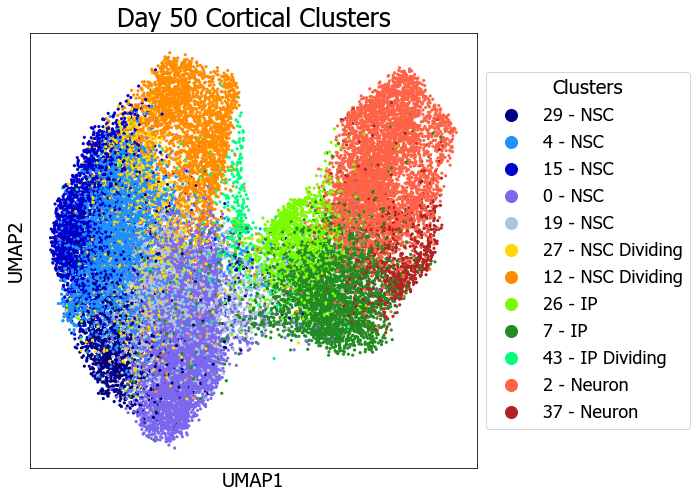

In [24]:
plt.figure(figsize=(10,8))
ax = plt.subplot(111)
clusts = sorted([int(x) for x in set(adata_merged.obs['louvain'])])
clrs = sns.color_palette('nipy_spectral', n_colors=len(clusts))  # a list of RGB tuples
final_colors = []
clrs_dict = {}
for j,cell in enumerate(sorted(set(adata_merged.obs['louvain']))):
    clrs_dict[cell] = clrs[j]

clrs_dict = {29:'navy',19:'lightsteelblue',4:'dodgerblue',0:'mediumslateblue',15:'mediumblue',
27:'gold',12:'darkorange',26:'lawngreen',7:'forestgreen',43:'springgreen',2:'tomato',37:'firebrick'}

for j,cell in enumerate(adata_merged.obs['louvain']):
    final_colors.append(clrs_dict[cell])

plt.scatter(adata_merged.obsm['X_umap'][:,0],adata_merged.obsm['X_umap'][:,1],c=final_colors,s=10,ec=None)
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
for j,cell_type in enumerate([29,4,15,0,19,27,12,26,7,43,2,37]):
    plt.plot(-10000,-10000,'.',color=clrs_dict[cell_type],label=str(cell_type)+' - '+cell_type_dict[int(cell_type)].replace('Cortical ',''),markersize=24)

plt.title('Day 50 Cortical Clusters', fontsize=26)
plt.xlabel('UMAP1',fontsize=20)
plt.ylabel('UMAP2',fontsize=20)
plt.xticks([])
plt.yticks([])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=18,title='Clusters',title_fontsize=20)
plt.savefig('figures/'+line_+'/UMAP.louvain.cortical.png',dpi=500,bbox_inches='tight')

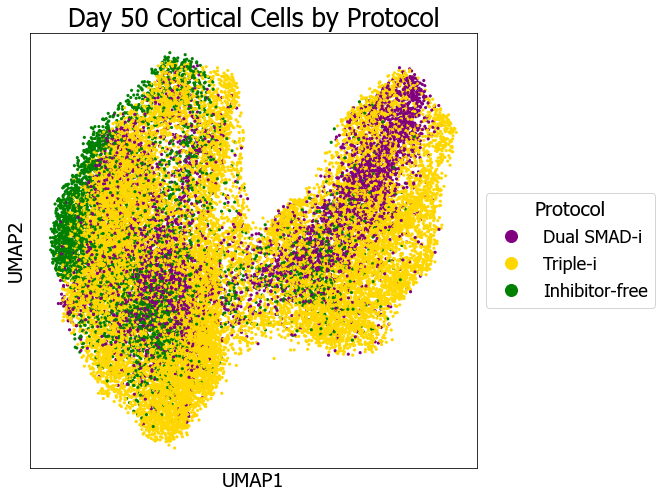

In [25]:
## overall fig
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
color_d = {'sbnx':'gold','sbn':'purple','nt':'green'}
tx_dict = {'sbnx':'Triple-i','sbn':'Dual SMAD-i','nt':'Inhibitor-free'}

xs = adata_merged.obsm['X_umap'][:,0]
ys = adata_merged.obsm['X_umap'][:,1]
colors = [color_d[line] for line in adata_merged.obs['tx']]
idx_list = list(range(len(xs)))
random.shuffle(idx_list)

plt.scatter(x=[xs[i] for i in idx_list],y=[ys[i] for i in idx_list],color=[colors[i] for i in idx_list],s=10,alpha=1,ec=None)
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
for tx in ['sbn','sbnx','nt']:
    plt.plot(-10000,-10000,'o',markersize=12,label=tx_dict[tx],color=color_d[tx])

plt.xticks([])
plt.yticks([])
plt.xlabel('UMAP1',fontsize=20)
plt.ylabel('UMAP2',fontsize=20)
#plt.title('Day 28 Organoid comparison by protocol',fontsize=44)
plt.title('Day 50 Cortical Cells by Protocol', fontsize=26)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=18,title='Protocol',title_fontsize=20)
plt.savefig('figures/'+line_+'/merged_umap.pdf',dpi=500,bbox_inches='tight')